##### Tensorflow implementation

In [8]:
from sklearn.datasets import load_sample_image
import numpy as np

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [9]:
batch_size, height, width, channels = images.shape

In [10]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [11]:
import tensorflow as tf

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

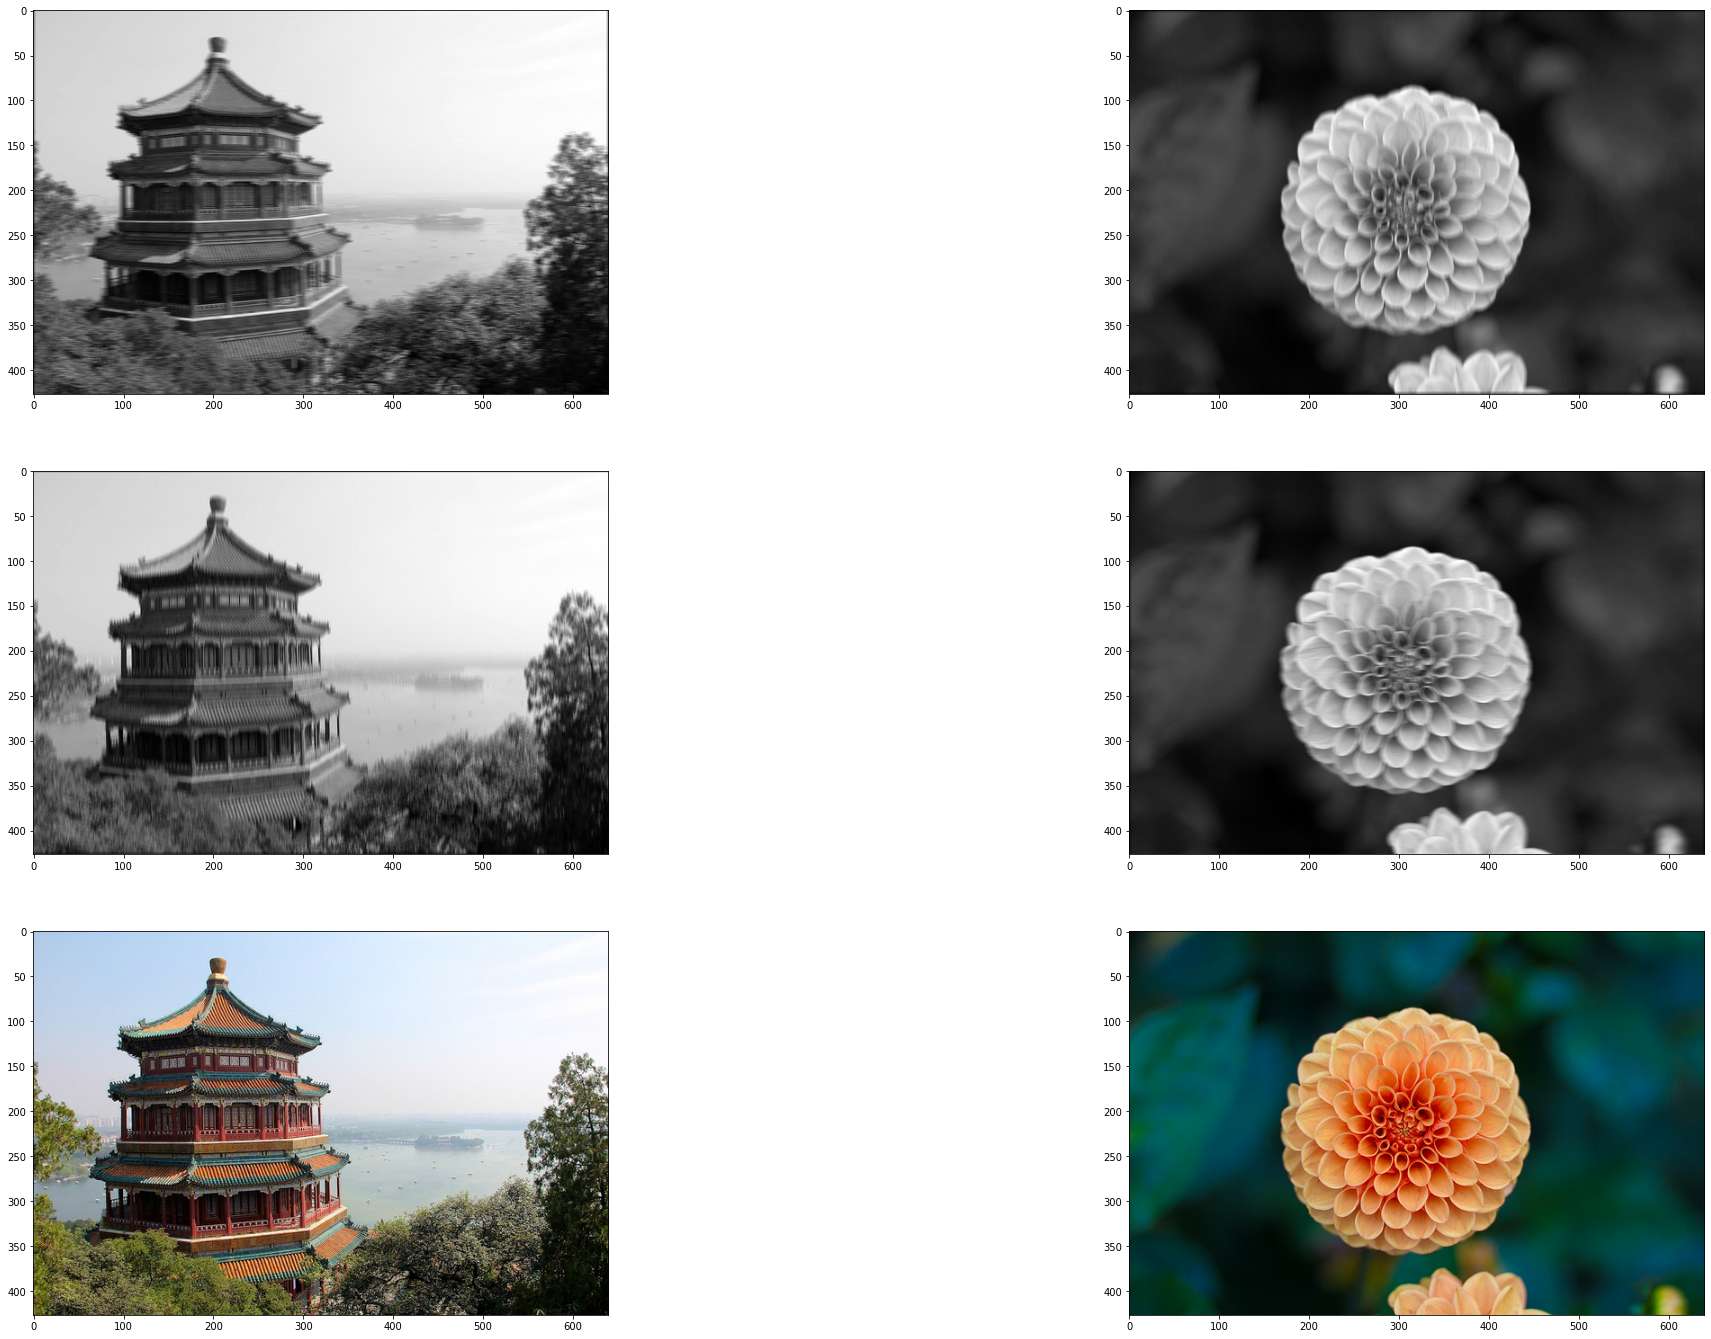

In [12]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(3, 2, figsize=(36, 24))
ax[0, 0].imshow(outputs[0, :, :, 1], cmap="gray")  # plot 1st image's 2nd feature map
ax[0, 1].imshow(outputs[1, :, :, 0], cmap="gray")
ax[1, 0].imshow(outputs[0, :, :, 0], cmap="gray")
ax[1, 1].imshow(outputs[1, :, :, 1], cmap="gray")
ax[2, 0].imshow(china, cmap="gray")
ax[2, 1].imshow(flower, cmap="gray")

plt.show()

In [13]:
# Example of keras layer
from tensorflow import keras

_ = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                        padding="SAME")  # kernel_size is the size of the receptive field

##### Tensorflow max pooling layer implementation example

In [15]:
_ = keras.layers.MaxPool2D(pool_size=2, strides=2, padding="SAME")
_ = keras.layers.AvgPool2D(pool_size=2, strides=2, padding="SAME")

##### Depth-wise pooling

In [16]:
_ = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")

UnimplementedError: Depthwise max pooling is currently only implemented for CPU devices. [Op:MaxPool]

In [17]:
# Custom layer
_ = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))

In [20]:
# Global average pooling layer
_ = keras.layers.GlobalAveragePooling2D()
_ = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

#### Tackling Fashion MNIST With a CNN

In [21]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [23]:
from functools import partial
from keras.models import Sequential

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model: Sequential = keras.models.Sequential(
    [DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), keras.layers.MaxPooling2D(pool_size=2),
     DefaultConv2D(filters=128), DefaultConv2D(filters=128), keras.layers.MaxPooling2D(pool_size=2),
     DefaultConv2D(filters=256), DefaultConv2D(filters=256), keras.layers.MaxPooling2D(pool_size=2),
     keras.layers.Flatten(), keras.layers.Dense(units=128, activation='relu'), keras.layers.Dropout(0.5),
     keras.layers.Dense(units=64, activation='relu'), keras.layers.Dropout(0.5),
     keras.layers.Dense(units=10, activation='softmax'), ])

In [24]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Epoch 1/10


2022-05-05 16:04:58.711601: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 8s 4ms/step - loss: 0.7003 - accuracy: 0.7591 - val_loss: 0.3742 - val_accuracy: 0.8632
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4211 - accuracy: 0.8593 - val_loss: 0.3223 - val_accuracy: 0.8858
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3582 - accuracy: 0.8803 - val_loss: 0.3354 - val_accuracy: 0.8830
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3287 - accuracy: 0.8889 - val_loss: 0.2821 - val_accuracy: 0.8992
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3053 - accuracy: 0.8973 - val_loss: 0.2894 - val_accuracy: 0.8986
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2892 - accuracy: 0.9019 - val_loss: 0.2758 - val_accuracy: 0.9000
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2747 - accuracy: 0.9054 - val_loss: 0.3073 - val_accuracy: 0.8990
Epo

In [25]:
score

[0.33052563667297363, 0.8937000036239624]

#### Implementing a ResNet-34 CNN Using Keras

In [27]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)


class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [DefaultConv2D(filters, strides=strides), keras.layers.BatchNormalization(), self.activation,
                            DefaultConv2D(filters), keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [DefaultConv2D(filters, kernel_size=1, strides=strides),
                                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [28]:

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

#### Using a pretrained model from Keras

In [30]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 9s 0us/step


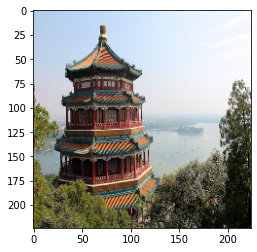

In [33]:
images_resized = tf.image.resize(images, [224, 224])
# plot_color_image(images_resized[0])
plt.imshow(images_resized[0])
plt.show()

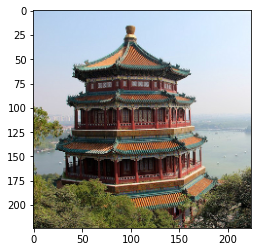

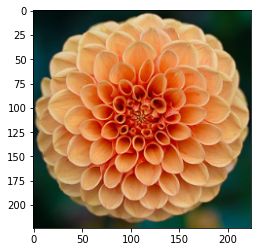

In [38]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plt.imshow(images_resized[0])
plt.show()
plt.imshow(images_resized[1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


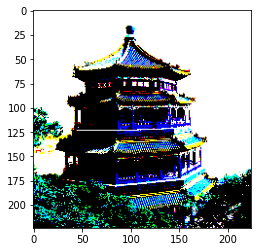

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


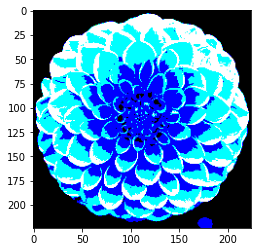

In [40]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
plt.imshow(inputs[0])
plt.show()
plt.imshow(inputs[1])
plt.show()

In [41]:
Y_proba = model.predict(inputs)

In [42]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.37%
  n02825657 - bell_cote    43.11%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.98%
  n07930864 - cup          9.53%
  n11939491 - daisy        4.96%



#### Pretrained Models for Transfer Learning